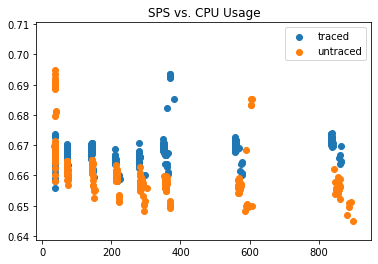

In [111]:
untraced = []
traced = []

SPS = 0
CPU = 1

def read_file(filename):
    with open(filename) as file:
        t = []
        while True:
            line = file.readline()
            if not line:
                break

            t.append([float(i) for i in line.split()])
    return t

traced = read_file('large_batch/traced.txt')
untraced = read_file('large_batch/untraced.txt')

sps_traced = [t[0] / t[1] for t in traced]
sps_untraced = [t[0] / t[1] for t in untraced]
cpu_traced = [t[2] / t[1] for t in traced]
cpu_untraced = [t[2] / t[1] for t in untraced]

plt.title("SPS vs. CPU Usage")
plt.scatter(sps_traced, cpu_traced, label='traced')
plt.scatter(sps_untraced, cpu_untraced, label='untraced')
plt.legend()
plt.show()


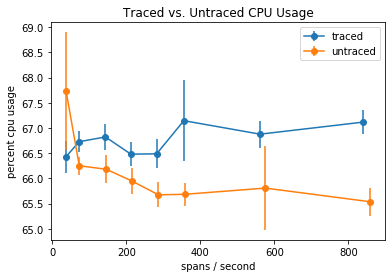

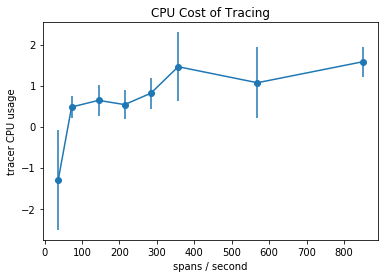

In [110]:
import numpy as np

groups = [1000, 2000, 4000, 6000, 8000, 10000, 16000, 24000]

filter_by_group = lambda array, group : list(filter(lambda elem : elem[0] == group, array))

traced_groups = [filter_by_group(traced, g) for g in groups]
untraced_groups = [filter_by_group(untraced, g) for g in groups]

mean_traced_cpu = [np.mean([a[2] / a[1] * 100 for a in array]) for array in traced_groups]
std_traced_cpu = [np.std([a[2] / a[1] * 100 for a in array]) for array in traced_groups]
mean_traced_sps = [np.mean([a[0] / a[1] for a in array]) for array in traced_groups]

plt.errorbar(mean_traced_sps, mean_traced_cpu, yerr=std_traced_cpu, label='traced', marker='o')

mean_untraced_cpu = [np.mean([a[2] / a[1] * 100 for a in array]) for array in untraced_groups]
std_untraced_cpu = [np.std([a[2] / a[1] * 100 for a in array]) for array in untraced_groups]
mean_untraced_sps = [np.mean([a[0] / a[1] for a in array]) for array in untraced_groups]

plt.errorbar(mean_untraced_sps, mean_untraced_cpu, yerr=std_untraced_cpu, label='untraced', marker='o')
plt.legend()
plt.xlabel("spans / second")
plt.ylabel("percent cpu usage")
plt.title("Traced vs. Untraced CPU Usage")
plt.show()

comb_cpu = [mean_traced_cpu[i] - mean_untraced_cpu[i] for i in range(len(std_untraced_cpu))]
std_comb_cpu = [(std_traced_cpu[i]**2 + std_untraced_cpu[i]**2)**.5 for i in range(len(std_untraced_cpu))]
comb_sps = [(mean_traced_sps[i] + mean_untraced_sps[i]) / 2 for i in range(len(std_untraced_cpu))]

plt.errorbar(comb_sps, comb_cpu, yerr=std_comb_cpu, marker='o')
plt.title("CPU Cost of Tracing")
plt.xlabel("spans / second")
plt.ylabel("tracer CPU usage")
plt.show()


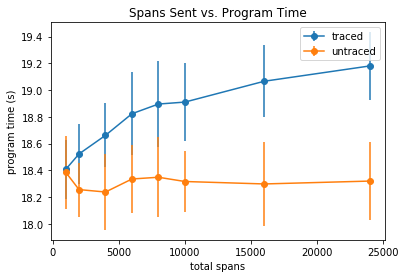

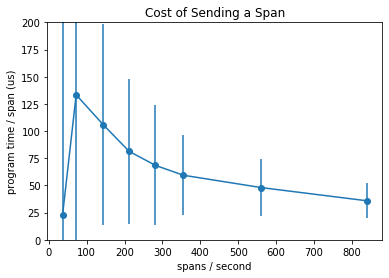

In [107]:
# Cost of a span...

# same for both !
sps = [np.mean([e[0] / e[1] for e in group]) for group in traced_groups]
total_spans = [group[0][0] for group in traced_groups]


mean_program_time_traced = [np.mean([e[2] for e in group]) for group in traced_groups]
std_program_time_traced = [np.std([e[2] for e in group]) for group in traced_groups]

mean_program_time_untraced = [np.mean([e[2] for e in group]) for group in untraced_groups]
std_program_time_untraced = [np.std([e[2] for e in group]) for group in untraced_groups]

# these are in us
time_per_span = [(mean_program_time_traced[i] - mean_program_time_untraced[i]) / total_spans[i] * 10**6 for i in range(len(total_spans))]
std_cost_per_span = [(std_program_time_traced[i]**2 + std_program_time_untraced[i]**2)**.5 / total_spans[i] * 10**6 for i in range(len(total_spans))]

plt.title("Spans Sent vs. Program Time")
plt.xlabel("total spans")
plt.ylabel("program time (s)")
plt.errorbar(total_spans, mean_program_time_traced, yerr=std_program_time_traced, label='traced', marker='o')
plt.errorbar(total_spans, mean_program_time_untraced, yerr=std_program_time_untraced, label='untraced', marker='o')
plt.legend()
plt.show()

plt.title("Cost of Sending a Span")
plt.ylabel("program time / span (us)")
plt.xlabel("spans / second")
plt.ylim(0, 200)
plt.errorbar(sps, time_per_span, yerr=std_cost_per_span, marker='o')
plt.show()

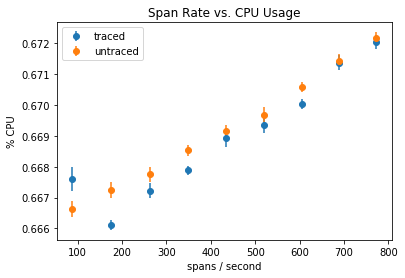

<ErrorbarContainer object of 3 artists>

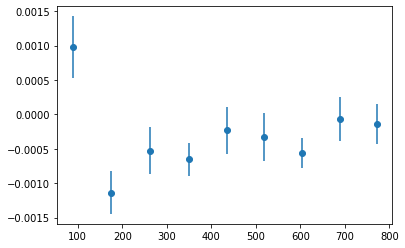

In [85]:
import numpy as np

traced_cpu = []
traced_cpu_std = []
traced_cpu_stderr = []
traced_sps = []

untraced_cpu = []
untraced_cpu_std = []
untraced_cpu_stderr = []
untraced_sps = []

for target_sps in [100, 175, 250, 350, 450, 525, 600, 700, 775]:
    traced_filter = list(filter(lambda x : abs(x[0] - target_sps) < 40, traced))
    untraced_filter = list(filter(lambda x : abs(x[0] - target_sps) < 40, untraced))
    
    traced_cpu.append(np.mean([t[2] for t in traced_filter]))
    traced_cpu_std.append(np.std([t[2] for t in traced_filter]))
    traced_sps.append(np.mean([t[0] for t in traced_filter]))
    traced_cpu_stderr.append(np.std([t[2] for t in traced_filter]) / np.sqrt(len(traced_filter)))
    
    untraced_cpu.append(np.mean([t[2] for t in untraced_filter]))
    untraced_cpu_std.append(np.std([t[2] for t in untraced_filter]))
    untraced_sps.append(np.mean([t[0] for t in untraced_filter]))
    untraced_cpu_stderr.append(np.std([t[2] for t in untraced_filter]) / np.sqrt(len(untraced_filter)))



plt.errorbar(traced_sps, traced_cpu, yerr=traced_cpu_stderr, fmt='o', label='traced')
plt.errorbar(untraced_sps, untraced_cpu, yerr=untraced_cpu_stderr, fmt='o', label='untraced')
plt.title("Span Rate vs. CPU Usage")
plt.xlabel("spans / second")
plt.ylabel("% CPU")
plt.legend()
plt.show()

combined_stderr = [ (traced_cpu_stderr[i]**2 + untraced_cpu_stderr[i]**2)**.5 for i in range(len(traced_cpu_stderr)) ]
difference = [traced_cpu[i] - untraced_cpu[i] for i in range(len(traced_cpu))]

plt.errorbar(traced_sps, difference, yerr=combined_stderr, fmt='o', label='traced')

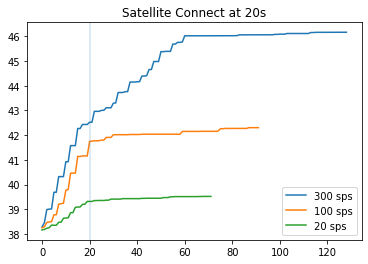

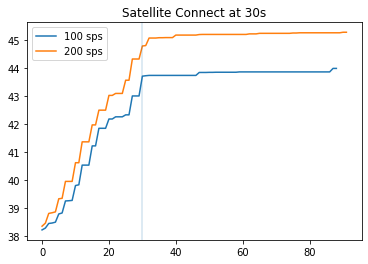

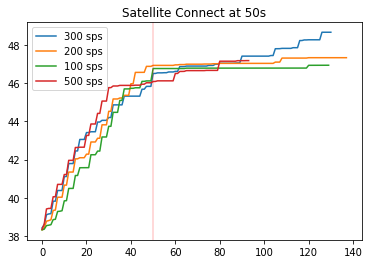

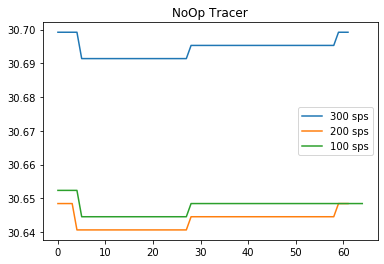

In [37]:
import matplotlib.pyplot as plt


memory_connect_20s_300sps = [38.2890625,38.46484375,38.9921875,39.0078125,39.015625,39.69140625,39.69140625,40.32421875,40.32421875,40.32421875,40.92578125,40.92578125,41.578125,41.578125,41.578125,42.26953125,42.26953125,42.43359375,42.43359375,42.43359375,42.5234375,42.5234375,42.96484375,42.96484375,42.96484375,43.00390625,43.0078125,43.109375,43.109375,43.109375,43.296875,43.3046875,43.7265625,43.7265625,43.7265625,43.76171875,43.76171875,44.1484375,44.1484375,44.1484375,44.1640625,44.1640625,44.390625,44.390625,44.40625,44.65625,44.65625,44.98046875,44.98046875,44.98046875,45.37890625,45.37890625,45.390625,45.390625,45.390625,45.68359375,45.68359375,45.75390625,45.75390625,45.76953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.01953125,46.0234375,46.0234375,46.0234375,46.0234375,46.0234375,46.0234375,46.0234375,46.0234375,46.0234375,46.02734375,46.02734375,46.05859375,46.05859375,46.05859375,46.05859375,46.05859375,46.05859375,46.05859375,46.0625,46.0625,46.0625,46.0625,46.0625,46.0625,46.0625,46.0625,46.078125,46.078125,46.0859375,46.0859375,46.0859375,46.11328125,46.11328125,46.11328125,46.11328125,46.11328125,46.11328125,46.11328125,46.11328125,46.11328125,46.11328125,46.15234375,46.15234375,46.16015625,46.16015625,46.16015625,46.16015625,46.16015625,46.1640625,46.1640625,46.1640625,46.1640625,46.1640625,46.1640625,46.1640625,46.1640625,46.1640625]
memory_connect_20s_100sps = [38.25390625,38.296875,38.46875,38.48828125,38.50390625,38.77734375,38.78515625,39.20703125,39.2265625,39.24609375,39.7734375,39.8046875,40.46484375,40.46484375,40.46484375,41.140625,41.140625,41.16015625,41.16015625,41.16015625,41.74609375,41.76171875,41.7734375,41.7734375,41.77734375,41.80078125,41.80078125,41.91015625,41.91015625,41.91015625,42.01953125,42.01953125,42.01953125,42.01953125,42.01953125,42.01953125,42.01953125,42.02734375,42.02734375,42.02734375,42.02734375,42.02734375,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.0390625,42.15234375,42.15234375,42.15234375,42.15234375,42.15234375,42.15234375,42.15234375,42.15234375,42.15625,42.15625,42.15625,42.15625,42.15625,42.15625,42.15625,42.1640625,42.26171875,42.26171875,42.2734375,42.2734375,42.2734375,42.2734375,42.2734375,42.2734375,42.2734375,42.2734375,42.2734375,42.2734375,42.3046875,42.3046875,42.3046875,42.3046875,42.3046875]
memory_connect_20s_20sps = [38.16796875,38.1875,38.234375,38.2578125,38.36328125,38.35546875,38.35546875,38.4765625,38.48046875,38.640625,38.6484375,38.65625,38.8671875,38.8671875,39.08203125,39.09375,39.09375,39.203125,39.203125,39.3203125,39.3203125,39.3203125,39.35546875,39.35546875,39.359375,39.359375,39.359375,39.37109375,39.37109375,39.4140625,39.4140625,39.4140625,39.4140625,39.4140625,39.43359375,39.43359375,39.43359375,39.43359375,39.43359375,39.43359375,39.43359375,39.43359375,39.4453125,39.4453125,39.44921875,39.44921875,39.44921875,39.44921875,39.44921875,39.44921875,39.44921875,39.4765625,39.4765625,39.4765625,39.5078125,39.5078125,39.515625,39.515625,39.515625,39.515625,39.515625,39.515625,39.515625,39.515625,39.515625,39.515625,39.51953125,39.51953125,39.5234375,39.5234375,39.5234375,39.5234375]
plt.plot(memory_connect_20s_300sps, label='300 sps')
plt.plot(memory_connect_20s_100sps, label='100 sps')
plt.plot(memory_connect_20s_20sps, label='20 sps')
plt.axvline(x=20, alpha=.2)
plt.legend()
plt.title("Satellite Connect at 20s")
plt.show()

memory_connect_30s_100sps = [38.2109375,38.27734375,38.44140625,38.45703125,38.48828125,38.78125,38.81640625,39.24609375,39.25390625,39.265625,39.796875,39.82421875,40.52734375,40.52734375,40.52734375,41.21484375,41.21484375,41.84375,41.84375,41.84375,42.17578125,42.17578125,42.25390625,42.25390625,42.25390625,42.32421875,42.32421875,43.0,43.0,43.0,43.70703125,43.72265625,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.734375,43.83984375,43.83984375,43.83984375,43.84375,43.84375,43.84765625,43.84765625,43.84765625,43.84765625,43.84765625,43.84765625,43.84765625,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.859375,43.984375,43.984375]
memory_connect_30s_200sps = [38.34375,38.453125,38.80078125,38.82421875,38.85546875,39.32421875,39.33984375,39.9453125,39.9453125,39.9453125,40.61328125,40.61328125,41.359375,41.359375,41.359375,41.96484375,41.96484375,42.4921875,42.4921875,42.4921875,43.01953125,43.01953125,43.08984375,43.08984375,43.08984375,43.5625,43.5625,44.3203125,44.3203125,44.3203125,44.78515625,44.80078125,45.0703125,45.0703125,45.0703125,45.08203125,45.08203125,45.0859375,45.0859375,45.0859375,45.17578125,45.17578125,45.17578125,45.17578125,45.17578125,45.17578125,45.17578125,45.1953125,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.19921875,45.21875,45.21875,45.21875,45.23828125,45.23828125,45.23828125,45.23828125,45.23828125,45.23828125,45.23828125,45.23828125,45.23828125,45.23828125,45.25,45.25,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.2578125,45.27734375,45.27734375]
plt.plot(memory_connect_30s_100sps, label='100 sps')
plt.plot(memory_connect_30s_200sps, label='200 sps')
plt.axvline(x=30, alpha=.2)
plt.title("Satellite Connect at 30s")
plt.legend()
plt.show()


memory_connect_50s_300sps = [38.41796875,38.5859375,39.109375,39.15234375,39.16796875,39.8203125,39.8203125,40.37890625,40.37890625,40.37890625,41.109375,41.109375,41.7890625,41.7890625,41.7890625,42.44921875,42.44921875,43.05078125,43.05078125,43.05078125,43.41015625,43.41015625,43.453125,43.453125,43.453125,43.9609375,43.9609375,44.05078125,44.05078125,44.05078125,44.19921875,44.19921875,44.859375,44.859375,44.859375,44.859375,44.859375,45.31640625,45.31640625,45.31640625,45.31640625,45.31640625,45.31640625,45.31640625,45.31640625,45.6796875,45.6796875,45.828125,45.828125,45.828125,46.50390625,46.50390625,46.53515625,46.53515625,46.53515625,46.54296875,46.54296875,46.58203125,46.58203125,46.58203125,46.61328125,46.61328125,46.86328125,46.86328125,46.86328125,46.890625,46.890625,46.890625,46.890625,46.890625,46.890625,46.890625,46.890625,46.890625,46.890625,46.921875,46.921875,46.921875,46.984375,46.984375,47.0390625,47.0390625,47.0390625,47.0390625,47.0390625,47.0390625,47.0390625,47.046875,47.0546875,47.0546875,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.41015625,47.44140625,47.44140625,47.796875,47.796875,47.80078125,47.81640625,47.81640625,47.81640625,47.81640625,47.81640625,47.8515625,47.8515625,47.8515625,48.2265625,48.2265625,48.2578125,48.2578125,48.265625,48.265625,48.265625,48.265625,48.265625,48.265625,48.66015625,48.66015625,48.66015625,48.66015625,48.66015625]
memory_connect_50s_100sps = [38.3203125,38.35546875,38.54296875,38.5625,38.58984375,38.85546875,38.87109375,39.28125,39.29296875,39.3203125,39.8359375,39.84765625,40.48828125,40.48828125,40.48828125,41.1640625,41.1640625,41.5703125,41.5703125,41.5703125,41.57421875,41.57421875,42.25,42.25,42.25,42.44140625,42.44140625,43.1796875,43.1796875,43.1796875,43.73828125,43.73828125,44.46875,44.46875,44.46875,45.09375,45.09375,45.6953125,45.6953125,45.6953125,45.7265625,45.7265625,45.75390625,45.75390625,45.75390625,46.08984375,46.08984375,46.11328125,46.11328125,46.11328125,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.76171875,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78125,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.78515625,46.9296875,46.9296875,46.9296875,46.9296875,46.9296875,46.93359375,46.93359375,46.93359375,46.93359375,46.93359375]
memory_connect_50s_200sps = [38.31640625,38.42578125,38.7734375,38.8046875,38.84765625,39.3359375,39.35546875,40.02734375,40.02734375,40.02734375,40.66015625,40.66015625,41.34375,41.34375,41.34375,42.03515625,42.03515625,42.09375,42.09375,42.09375,42.28125,42.28125,42.91796875,42.91796875,42.91796875,43.11328125,43.11328125,43.81640625,43.81640625,43.81640625,44.5234375,44.5234375,45.16796875,45.16796875,45.16796875,45.21875,45.21875,45.359375,45.359375,45.359375,45.96484375,45.96484375,46.55859375,46.55859375,46.55859375,46.5625,46.5625,46.875,46.875,46.875,46.92578125,46.92578125,46.92578125,46.92578125,46.92578125,46.92578125,46.92578125,46.92578125,46.92578125,46.92578125,46.953125,46.953125,46.96875,46.96875,46.96875,46.98828125,46.98828125,46.98828125,46.98828125,46.98828125,46.98828125,46.98828125,46.98828125,46.99609375,46.99609375,46.99609375,46.99609375,47.01171875,47.01171875,47.01171875,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.03125,47.09765625,47.09765625,47.09765625,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.30859375,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125,47.328125]
memory_connect_50s_500sps = [38.35546875,38.6328125,39.4140625,39.44140625,39.44140625,40.05078125,40.05078125,40.69921875,40.69921875,40.69921875,41.21484375,41.21484375,41.95703125,41.95703125,41.95703125,42.62890625,42.62890625,42.64453125,42.64453125,42.64453125,43.26171875,43.26171875,43.859375,43.859375,43.859375,44.4140625,44.4140625,45.05859375,45.05859375,45.05859375,45.76171875,45.76171875,45.84765625,45.84765625,45.84765625,45.87890625,45.87890625,45.87890625,45.87890625,45.87890625,45.87890625,45.87890625,45.890625,45.890625,45.890625,45.94140625,45.94140625,46.015625,46.015625,46.015625,46.08203125,46.0859375,46.1171875,46.1171875,46.1171875,46.1171875,46.1171875,46.1171875,46.1171875,46.1171875,46.50390625,46.50390625,46.609375,46.609375,46.61328125,46.65234375,46.65234375,46.65234375,46.65234375,46.65234375,46.65234375,46.65234375,46.65234375,46.65234375,46.6640625,46.6640625,46.6640625,46.6640625,46.6640625,46.6640625,47.14453125,47.14453125,47.14453125,47.14453125,47.14453125,47.14453125,47.14453125,47.14453125,47.171875,47.171875,47.171875,47.171875,47.17578125,47.17578125]
plt.plot(memory_connect_50s_300sps, label='300 sps')
plt.plot(memory_connect_50s_200sps, label='200 sps')
plt.plot(memory_connect_50s_100sps, label='100 sps')
plt.plot(memory_connect_50s_500sps, label='500 sps')
plt.axvline(x=50, alpha=.2)
plt.title("Satellite Connect at 50s")
plt.legend()
plt.show()

untraced_100sps = [30.65234375,30.65234375,30.65234375,30.65234375,30.65234375,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375,30.6484375]
untraced_200sps = [30.6484375,30.6484375,30.6484375,30.6484375,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.640625,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.64453125,30.6484375,30.6484375,30.6484375]
untraced_300sps = [30.69921875,30.69921875,30.69921875,30.69921875,30.69921875,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.69140625,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.6953125,30.69921875,30.69921875,30.69921875]
plt.plot(untraced_300sps, label="300 sps")
plt.plot(untraced_200sps, label="200 sps")
plt.plot(untraced_100sps, label="100 sps")
plt.legend()
plt.title("NoOp Tracer")
plt.show()



In [ ]:
# mock spanner that is guarenteed to do nothing...

